# Relationship between cell size and other variables

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.legend import Legend
import seaborn as sns
from matplotlib import colors as colorsm

In [2]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

In [3]:
from scipy.stats import pearsonr, linregress, zscore, gmean, shapiro, kstest, spearmanr, boxcox, rankdata, kendalltau, norm, t

In [4]:
from skbio import TreeNode

In [5]:
from matplotlib.ticker import ScalarFormatter

In [6]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [7]:
from scipy.stats import gaussian_kde, mannwhitneyu, ttest_ind, levene
from scipy.interpolate import griddata

In [8]:
from pylr2 import regress2

In [9]:
#%matplotlib widget
# %matplotlib notebook

In [10]:
plt.rcParams.update({
    'figure.autolayout': True,
    'savefig.bbox': 'tight',
    'svg.fonttype': 'none',
    'font.sans-serif': 'Arial',
    'font.size': 11,
    'boxplot.medianprops.linewidth': 2,
    'boxplot.flierprops.markeredgecolor': 'none',
    'boxplot.flierprops.markersize': 5})

In [11]:
def sig_sign(p):
    if p > 0.05:
        return 'ns'
    elif p > 0.01:
        return '*'
    elif p > 0.001:
        return '**'
    elif p > 0.0001:
        return '***'
    else:
        return '****'

Load data

In [12]:
df = pd.read_table('../phylogeny/place/fine_all.tsv', index_col = 0)
df.shape

(5380, 22)

Get volume-to-surface ratio

In [13]:
df['svratio'] = df['volume'] / df['surface']

In [14]:
df.columns

Index(['length', 'width', 'volume', 'surface', 'shape', 'species', 'genus',
       'family', 'order', 'class', 'phylum', 'kingdom', 'rank', 'node',
       'genome', 'gc', 'proteins', 'coding', 'rrnas', 'MILC', 'ENCprime',
       'hash', 'svratio'],
      dtype='object')

Log transform variables

In [15]:
for col in ['svratio', 'volume', 'surface', 'length', 'width', 'genome', 'proteins']:
    df[f'log_{col}'] = np.log10(df[col])

Arcsine transformation for proportional data

In [16]:
df['arc_coding'] = np.arcsin(np.sqrt(df['coding'] / 100))
df['arc_gc'] = np.arcsin(np.sqrt(df['gc'] / 100))

### Get species with available genomic information

In [17]:
df1 = df[df['node'].str.contains('G')].copy()

**Because of our methodology (phylogenetic placement) some species have been assigned to the same genome, so we need to get rid of the duplicates and select only those species whose taxonomic name matches the genome name**

In [18]:
dft = pd.read_table('../phylogeny/tax2tree/filled_ranks.tsv', index_col = 0)

In [19]:
df1['is_species'] = df1['node'].apply(lambda x: dft.loc[x]['species'] if x in dft.index else np.nan)

In [20]:
df1 = df1[df1['species'] == df1['is_species']]

In [21]:
df1.shape

(1363, 33)

### Load full tree

In [22]:
tree = TreeNode.read('../phylogeny/place/fine_all.nwk')
print(f'Tree tips {tree.count()}')
print(f'Tree tips {tree.count(tips = True)}')

Tree tips 7341
Tree tips 5380


Prune tree to contain only taxa with genomic information

In [23]:
woltree = tree.copy()

In [24]:
woltree = woltree.shear(df1.index)
woltree.prune()

In [25]:
print(f'Tree tips {woltree.count()}')
print(f'Tree tips {woltree.count(tips = True)}')

Tree tips 2695
Tree tips 1363


Save tree and metadata

In [26]:
woltree.write('../phylogeny/place/fine_all_wol.nwk')

'../phylogeny/place/fine_all_wol.nwk'

In [27]:
df1.to_csv('../phylogeny/place/fine_all_wol.tsv', sep = '\t')

In [28]:
# # Save taxa
# with open('genomes_genomic_information.txt', 'w') as f:
#     for idx in df1.index:
#         f.write(f'{idx}\n')

## Spearman correlation

In [29]:
cols = ['log_svratio', 'log_genome', 'log_proteins', 'arc_gc', 'arc_coding', 'rrnas', 'ENCprime']

In [30]:
xlabels = ['Log (Volume-to-surface\nratio, $\\mu m$)',
           'Log(Genome\nsize, bp)', 'Log(Number\nof proteins)', 'Arcsine(GC\ncontent, %)', 
          'Arcsine(Coding\ndensity, %)', '16S rRNA\ncopies', "$\\Delta$ENC\'"]

In [31]:
dfc = spearmanr(df1[cols])

In [32]:
print(dfc[0])

[[ 1.          0.20605884  0.22210027  0.057      -0.29950561  0.07274478
   0.1215254 ]
 [ 0.20605884  1.          0.97558614  0.27708526 -0.15802036  0.04613714
   0.21527003]
 [ 0.22210027  0.97558614  1.          0.28050577 -0.1777517   0.01149523
   0.20995   ]
 [ 0.057       0.27708526  0.28050577  1.          0.23665021 -0.00118869
  -0.17529033]
 [-0.29950561 -0.15802036 -0.1777517   0.23665021  1.         -0.0500306
  -0.17268119]
 [ 0.07274478  0.04613714  0.01149523 -0.00118869 -0.0500306   1.
  -0.02176939]
 [ 0.1215254   0.21527003  0.20995    -0.17529033 -0.17268119 -0.02176939
   1.        ]]


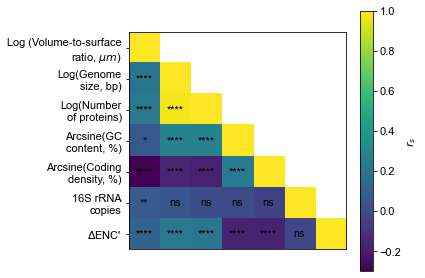

In [33]:
fig, ax = plt.subplots()

# Lower triangular
mask = np.triu(np.ones_like(dfc[0], dtype = bool), k = 1)
# Upper triangular
# mask = np.tri(dfc[0].shape[0], k = -1)

data = np.ma.array(dfc[0], mask = mask)
im = ax.imshow(data,  cmap = 'viridis')

ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks(np.arange(len(cols)))
ax.set_yticklabels(xlabels)
plt.setp(ax.get_xticklabels(), rotation = 90, ha = "center")

cb = fig.colorbar(im, ax = ax, orientation = 'vertical', location = 'right')
cb.set_label('$r_s$')

# Text annotation with pvalues
for i in range(len(cols)):
    for j in range(len(cols)):
        if  i > j:
            text = plt.text(j, i, sig_sign(dfc[1][i, j]),
                           ha = "center", va = "center", color = "black")


#plt.title('Spearman correlation coefficient')
plt.savefig('../figures_all/fig6_sup.svg')
plt.show()

## Linear regression

Load data from Phylogenetic Least Square Regression

In [34]:
df_pgls = pd.read_csv('../phylosig/physig/PGLS_wol.tsv', sep = '\t')

In [35]:
cols = ['log_genome', 'log_proteins', 'arc_gc', 'arc_coding', 'rrnas', 'ENCprime']

In [36]:
ylabels = ['Log(Genome size, bp)', 'Log(Number of proteins)', 'Arcsine(GC content, %)', 
          'Arcsine(Coding density, %)', '16S rRNA copies', "$\\Delta$ENC\'"]

Critical value for confidence interval estimation

In [37]:
degrees_freedom = len(df1['log_svratio']) - 2
alpha = 0.05
critical_value = t.pdf(1 - alpha / 2, degrees_freedom)


Genome property: log_genome
OLS summary:                             OLS Regression Results                            
Dep. Variable:             log_genome   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     108.7
Date:                Fri, 08 Dec 2023   Prob (F-statistic):           1.52e-24
Time:                        17:56:40   Log-Likelihood:                 435.25
No. Observations:                1363   AIC:                            -866.5
Df Residuals:                    1361   BIC:                            -856.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const   


Genome property: ENCprime
OLS summary:                             OLS Regression Results                            
Dep. Variable:               ENCprime   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     7.132
Date:                Fri, 08 Dec 2023   Prob (F-statistic):            0.00766
Time:                        17:56:41   Log-Likelihood:                 1501.7
No. Observations:                1363   AIC:                            -2999.
Df Residuals:                    1361   BIC:                            -2989.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const     

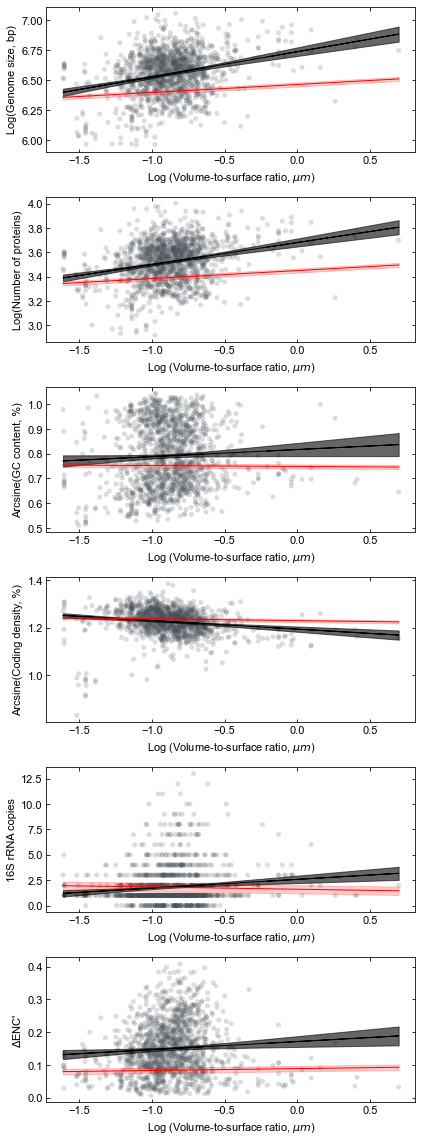

In [38]:
fig, ax = plt.subplots(len(cols), 1, figsize = (6, 16))

size = 'log_svratio'
for i, col in enumerate(cols):
    
    x = sm.add_constant(df1[size])
    y = df1[col]
    reg = sm.OLS(y, x).fit()
    intercept, slope = reg.params
        
    x_ = np.linspace(df1[size].min(), df1[size].max(), df1[size].shape[0])
    y_pred = reg.get_prediction(sm.add_constant(x_))
        
    residuals = y - reg.predict()
    parameters = norm.fit(residuals)
    KS = kstest(residuals, 'norm', parameters)
    
        
    # Plots - OLS
    ax[i].scatter(df1[size], y, alpha = 0.2, ec = 'none', color = '#495057', s = 25)
    ax[i].plot(df1[size], (df1[size] * slope + intercept), c= 'k', lw = 1)
    ax[i].fill_between(x_, *zip(*y_pred.conf_int()), color = 'k', alpha = 0.6)
    ax[i].set_xlabel(f'Log (Volume-to-surface ratio, $\\mu m$)')
    ax[i].set_ylabel(f'{ylabels[i]}')
    ax[i].tick_params(top = True, right = True, direction = 'in', which = 'both')
    # Plots - PGLS
    datum = df_pgls.query(f"x == '{size}' and y == '{col}'")
    datum_y_pred = x_ * datum['slope'].values[0] + datum['intercept'].values[0]
    std_error_regression = np.sqrt( 
        (datum['std.slope'].values[0] ** 2 * (x_ - np.mean(x_)) ** 2) + (datum['std.intercept'].values[0] ** 2)
    )
    datum_ci_lower = datum_y_pred - critical_value * std_error_regression
    datum_ci_upper = datum_y_pred + critical_value * std_error_regression
    ax[i].plot(x_, datum_y_pred, c = 'red', lw = 1)
    ax[i].fill_between(x_, datum_ci_lower, datum_ci_upper, color = 'red', alpha = 0.2)
       
    # Spearman correlation coefficient
    pr = spearmanr(df1[size], y)
    
    print(f'\nGenome property: {col}')
    print(f'OLS summary: {reg.summary()}')
    print(f'Nomality residuals: {KS}')
    print(f'Spearman rank correlation: {pr}')
    
plt.savefig('../figures_all/svratio_genome_traits.svg')
plt.show()

Using volume


Genome property: log_genome
OLS summary:                             OLS Regression Results                            
Dep. Variable:             log_genome   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     79.09
Date:                Fri, 08 Dec 2023   Prob (F-statistic):           1.84e-18
Time:                        17:56:43   Log-Likelihood:                 421.37
No. Observations:                1363   AIC:                            -838.7
Df Residuals:                    1361   BIC:                            -828.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     


Genome property: ENCprime
OLS summary:                             OLS Regression Results                            
Dep. Variable:               ENCprime   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9685
Date:                Fri, 08 Dec 2023   Prob (F-statistic):              0.325
Time:                        17:56:44   Log-Likelihood:                 1498.6
No. Observations:                1363   AIC:                            -2993.
Df Residuals:                    1361   BIC:                            -2983.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

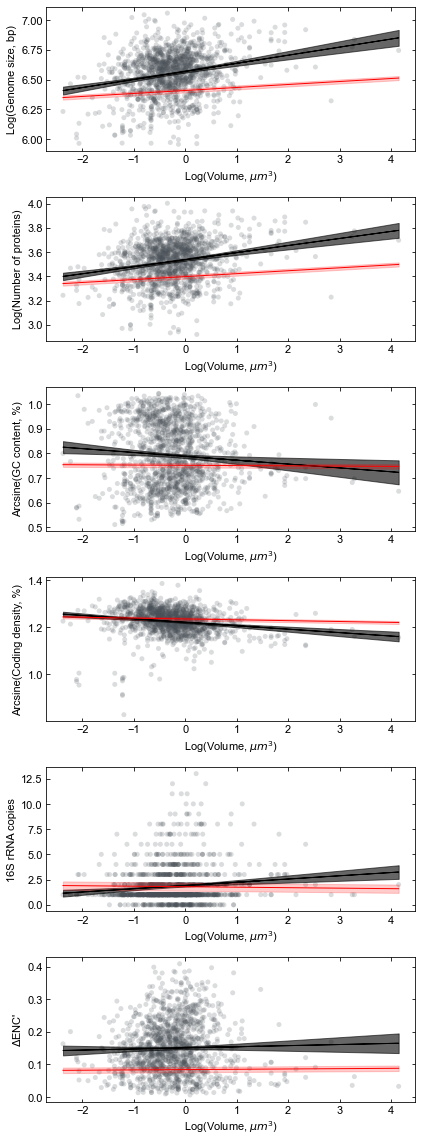

In [39]:
fig, ax = plt.subplots(len(cols), 1, figsize = (6, 16))

size = 'log_volume'
for i, col in enumerate(cols):
    
    x = sm.add_constant(df1[size])
    y = df1[col]
    reg = sm.OLS(y, x).fit()
    intercept, slope = reg.params
        
    x_ = np.linspace(df1[size].min(), df1[size].max(), df1[size].shape[0])
    y_pred = reg.get_prediction(sm.add_constant(x_))
        
    residuals = y - reg.predict()
    parameters = norm.fit(residuals)
    KS = kstest(residuals, 'norm', parameters)
    
        
    # Plots
    ax[i].scatter(df1[size], y, alpha = 0.2, ec = 'none', color = '#495057', s = 25)
    ax[i].plot(df1[size], (df1[size] * slope + intercept), c= 'k', lw = 1)
    ax[i].fill_between(x_, *zip(*y_pred.conf_int()), color = 'k', alpha = 0.6)
    ax[i].set_xlabel(f'Log(Volume, $\\mu m^3$)')
    ax[i].set_ylabel(f'{ylabels[i]}')
    ax[i].tick_params(top = True, right = True, direction = 'in', which = 'both')
    # Plots - PGLS
    datum = df_pgls.query(f"x == '{size}' and y == '{col}'")
    datum_y_pred = x_ * datum['slope'].values[0] + datum['intercept'].values[0]
    std_error_regression = np.sqrt( 
        (datum['std.slope'].values[0] ** 2 * (x_ - np.mean(x_)) ** 2) + (datum['std.intercept'].values[0] ** 2)
    )
    datum_ci_lower = datum_y_pred - critical_value * std_error_regression
    datum_ci_upper = datum_y_pred + critical_value * std_error_regression
    ax[i].plot(x_, datum_y_pred, c = 'red', lw = 1)
    ax[i].fill_between(x_, datum_ci_lower, datum_ci_upper, color = 'red', alpha = 0.2)
       
    # Spearman correlation coefficient
    pr = spearmanr(df1[size], y)
    
    print(f'\nGenome property: {col}')
    print(f'OLS summary: {reg.summary()}')
    print(f'Nomality residuals: {KS}')
    print(f'Spearman rank correlation: {pr}')
    
plt.savefig('../figures_all/vol_genome_traits.svg')
plt.show()

## Reducedd major axis regressions

* Relationship between variables is symmetrical
* Both variables are assume to contain errors, contrary to OLS that only assumes error in the y variable.


Genome property: log_genome
RMA summary: intercept: 7.23, slope: 0.77, r: 0.27
Nomality residuals: KstestResult(statistic=0.033936189769842695, pvalue=0.08464503369073062)
Spearman rank correlation: SpearmanrResult(correlation=0.20605884349407955, pvalue=1.5532476968624597e-14)

Genome property: log_proteins
RMA summary: intercept: 4.14, slope: 0.71, r: 0.25
Nomality residuals: KstestResult(statistic=0.03852570757232693, pvalue=0.03407341225255578)
Spearman rank correlation: SpearmanrResult(correlation=0.22210027088209774, pvalue=1.0768936454541179e-16)

Genome property: arc_gc
RMA summary: intercept: 1.28, slope: 0.55, r: 0.05
Nomality residuals: KstestResult(statistic=0.02755732851338301, pvalue=0.24726960924172403)
Spearman rank correlation: SpearmanrResult(correlation=0.05699999643152652, pvalue=0.03536507906304203)

Genome property: arc_coding
RMA summary: intercept: 1.02, slope: -0.23, r: -0.15
Nomality residuals: KstestResult(statistic=0.07795669461340843, pvalue=1.188707496147

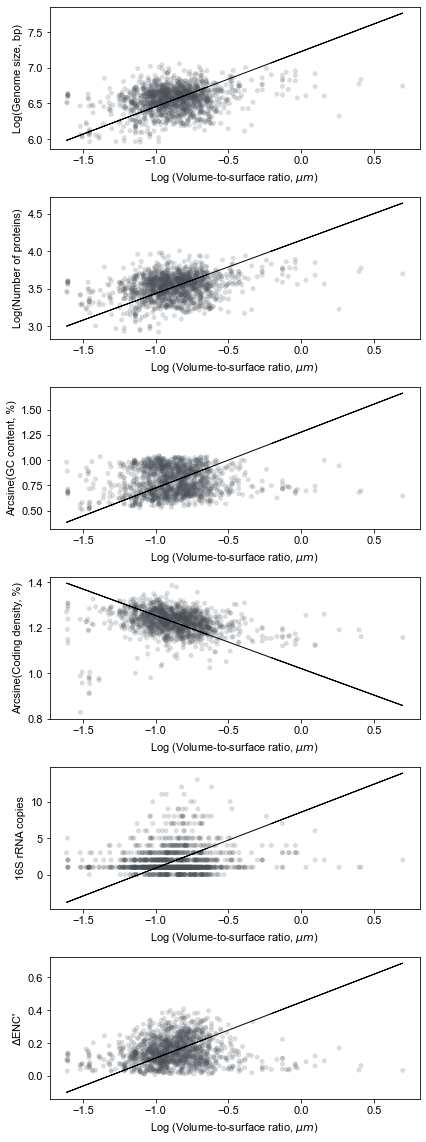

In [40]:
fig, ax = plt.subplots(len(cols), 1, figsize = (6, 16))

size = 'log_svratio'
for i, col in enumerate(cols):
    
    y = df1[col]
    x = df1[size]
    results = regress2(x, y, _method_type_2 = 'reduced major axis')
    intercept, slope, r, std_intercept, std_slope = results['intercept'], results['slope'], results['r'], results['std_intercept'], results['std_intercept']
        
    residuals = y - results['predict']
    parameters = norm.fit(residuals)
    KS = kstest(residuals, 'norm', parameters)
        
    # Plots
    ax[i].scatter(x, y, alpha = 0.2, ec = 'none', color = '#495057', s = 25)
    ax[i].plot(x, results['predict'], c = 'k', lw = 1)
#     ax[i].fill_between(x_, *zip(*y_pred.conf_int()), color = 'k', alpha = 0.6)
    ax[i].set_ylabel(f'{ylabels[i]}')
    ax[i].set_xlabel(f'Log (Volume-to-surface ratio, $\\mu m$)')
       
    # Spearman correlation coefficient
    pr = spearmanr(x, y)
    
    print(f'\nGenome property: {col}')
    print(f'RMA summary: intercept: {intercept:.2f}, slope: {slope:.2f}, r: {r:.2f}')
    print(f'Nomality residuals: {KS}')
    print(f'Spearman rank correlation: {pr}')
    
plt.show()


Genome property: log_genome
RMA summary: intercept: 6.62, slope: 0.29, r: 0.23
Nomality residuals: KstestResult(statistic=0.03776400659884588, pvalue=0.03994514959433748)
Spearman rank correlation: SpearmanrResult(correlation=0.17711146510448822, pvalue=4.552775679379241e-11)

Genome property: log_proteins
RMA summary: intercept: 3.59, slope: 0.27, r: 0.22
Nomality residuals: KstestResult(statistic=0.03852459693878785, pvalue=0.03408139080831629)
Spearman rank correlation: SpearmanrResult(correlation=0.19083577104502222, pvalue=1.2088469046258596e-12)

Genome property: arc_gc
RMA summary: intercept: 0.74, slope: -0.21, r: -0.08
Nomality residuals: KstestResult(statistic=0.026482030344211316, pvalue=0.2895889587659759)
Spearman rank correlation: SpearmanrResult(correlation=-0.07710495006050022, pvalue=0.0043959855516471835)

Genome property: arc_coding
RMA summary: intercept: 1.20, slope: -0.09, r: -0.17
Nomality residuals: KstestResult(statistic=0.07531834130566897, pvalue=3.595645542

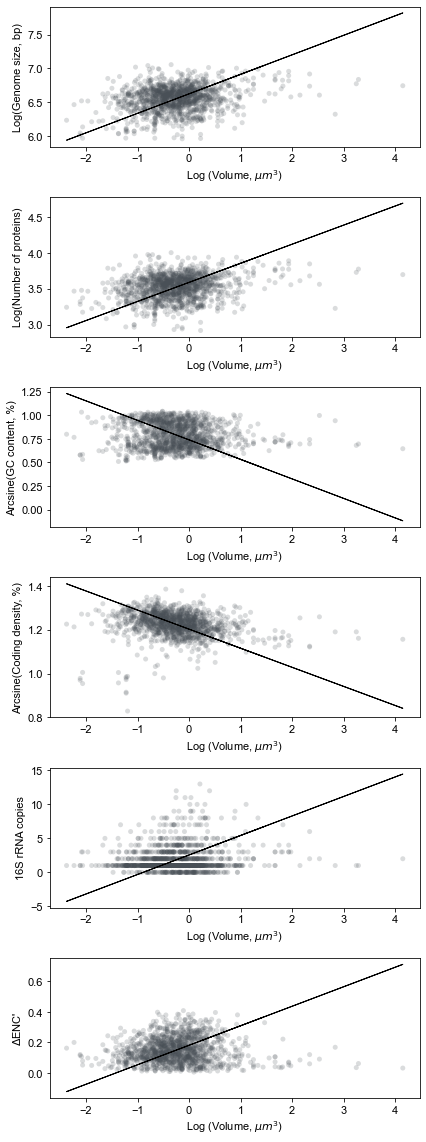

In [41]:
fig, ax = plt.subplots(len(cols), 1, figsize = (6, 16))

size = 'log_volume'
for i, col in enumerate(cols):
    
    y = df1[col]
    x = df1[size]
    results = regress2(x, y, _method_type_2 = 'reduced major axis')
    intercept, slope, r, std_intercept, std_slope = results['intercept'], results['slope'], results['r'], results['std_intercept'], results['std_intercept']
        
    residuals = y - results['predict']
    parameters = norm.fit(residuals)
    KS = kstest(residuals, 'norm', parameters)
        
    # Plots
    ax[i].scatter(x, y, alpha = 0.2, ec = 'none', color = '#495057', s = 25)
    ax[i].plot(x, results['predict'], c = 'k', lw = 1)
#     ax[i].fill_between(x_, *zip(*y_pred.conf_int()), color = 'k', alpha = 0.6)
    ax[i].set_ylabel(f'{ylabels[i]}')
    ax[i].set_xlabel(f'Log (Volume, $\\mu m^3$)')
       
    # Spearman correlation coefficient
    pr = spearmanr(x, y)
    
    print(f'\nGenome property: {col}')
    print(f'RMA summary: intercept: {intercept:.2f}, slope: {slope:.2f}, r: {r:.2f}')
    print(f'Nomality residuals: {KS}')
    print(f'Spearman rank correlation: {pr}')
    
plt.show()